In [1]:
#

import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from photutils.psf import CircularGaussianPRF

import matplotlib.pyplot as plt


fname = ['R2233018P.fit', 'R1948360P.fit', 
         'R2128554P.fit', '_0001.fit',
         'R2104061P.fit']

/home/lrikozavr/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read fits
ffile = fits.open(fname[0])
data = ffile[0].data.transpose()
head = ffile[0].header

In [3]:
# Get statistics
data = (data-np.min(data)).astype(np.uint16)
mean, median, std = sigma_clipped_stats(data, sigma=3)
threshold = median + (5. * std)
print(mean, median, std, threshold)

2503.743728322326 2465.0 199.06961285163254 3460.3480642581626


In [4]:
%%time

# Detect sources
# https://photutils.readthedocs.io/en/2.0.0/user_guide/psf.html
# maybe should pay attention to http://www.aspylib.com/

FWHM = 5.
R = int(FWHM*4) // 2 + 1

psf_model = CircularGaussianPRF(flux=mean*3, fwhm=FWHM*10)
fit_shape = (R, R)
finder = DAOStarFinder(std*6, FWHM)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=R)
phot = psfphot(data)


CPU times: user 126 ms, sys: 1.59 ms, total: 127 ms
Wall time: 132 ms


In [5]:

phot

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,0.0,4.126532824994464,2.196179951553548,533247.2093215885,5.075302338830375,3.549512408507831,533247.212448385,239.53856719282527,299.4714003737678,823173.8822312434,80,0.36183326647978464,0.004319817043063548,1
2,2,1,0.0,762.5976229762585,3.2727716662001303,411569.72815296927,761.7135313512681,4.324278613750746,411569.7332963591,193.27709199829604,214.73100556706572,522286.7109030614,90,0.337636894966369,0.004065614251071513,1
3,3,1,0.0,192.14576092032078,148.6178157516318,1091044.6455864739,192.026895319703,148.92046216754053,1091044.64669789,97.80274130810314,97.80230728839004,742079.596809404,121,0.3060402025333466,0.0035735631353357475,0
4,4,1,0.0,162.78517868213774,180.9846889945878,1393163.524910721,163.0213801242751,180.9055160150819,1393163.5256652297,121.83186426758311,121.83126948738268,1180456.2757319417,121,0.3708587682762991,0.0056886973508610515,0
5,5,1,0.0,2.7092417501216346,233.53295759009924,643724.8850459419,4.500244814713082,233.96223243184028,643724.8866995507,172.025663977603,140.87454428120648,641673.0029845058,99,0.3213736883035982,0.0038546946486230746,1
6,6,1,0.0,258.1151466612619,268.2809438434166,1203069.0443890656,258.0687144124922,267.99789320555885,1203069.0447646615,117.22625255941742,117.22565982598364,980821.7109811617,121,0.3570540482091255,0.005659173901510527,0
7,7,1,0.0,328.2872609755222,287.7225372232957,1084858.788915922,328.07777375805887,287.8742442797312,1084858.7893184922,108.3211995603102,108.31943916515131,817786.3929648172,121,0.33237843047851495,0.005492978965026375,0
8,8,1,0.0,87.66196649183992,363.8054167252182,1080061.4526658552,87.96854542880911,363.9034797412008,1080061.4536148382,98.81867742777554,98.8180747287278,742230.8473498914,121,0.3083958755541124,0.003913476216665493,0
9,9,1,0.0,716.815712694433,369.4788394257609,1562660.5837824973,716.9533136596339,369.13261360156196,1562660.5840906452,166.1004724285265,166.10324408718256,1806560.5073931105,121,0.4597115149647811,0.009762496415874514,0


(0.0, 34.170488127794066)

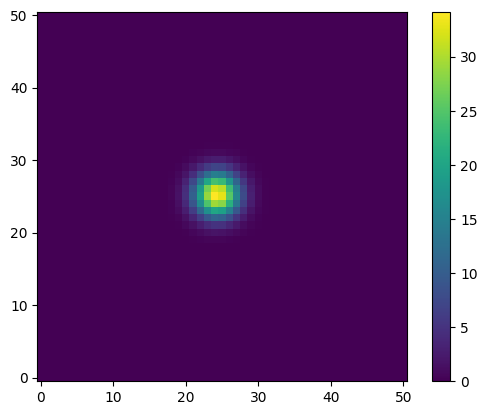

In [126]:
import matplotlib.pyplot as plt
import numpy as np
from photutils.psf import CircularGaussianPRF
model = CircularGaussianPRF(flux=1000, x_0=24.3, y_0=25.2, fwhm=5)
yy, xx = np.mgrid[0:51, 0:51]
data = model(xx, yy)
plt.imshow(data, origin='lower', interpolation='nearest')
plt.colorbar()
data.min(),data.max()

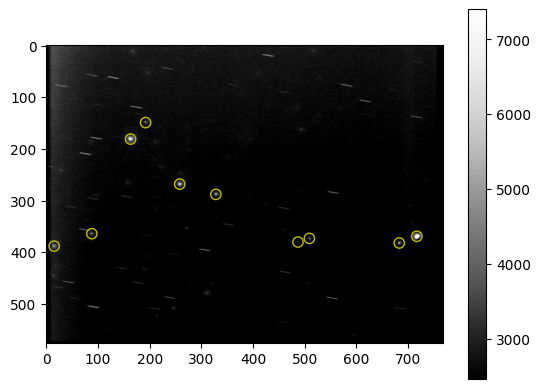

In [6]:
#print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

xy = [ [rec['x_fit'], rec['y_fit']] for rec in phot if rec["flags"] == 0]

# Draw data
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=10.0).plot(color="y")
plt.colorbar()
plt.show()

In [202]:
%%time
import time
def func(VALUE):
    time1 = time.time()
    finder = DAOStarFinder(VALUE, FWHM)
    psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                            aperture_radius=R)
    phot = psfphot(data)
    return len(phot[phot["flags"] == 0]), time.time() - time1


grapf1 = np.zeros((20,2))

for i in range(2,20,1):
    grapf1[i,:] = func(std*i)


CPU times: user 9.82 s, sys: 3.95 ms, total: 9.82 s
Wall time: 9.82 s


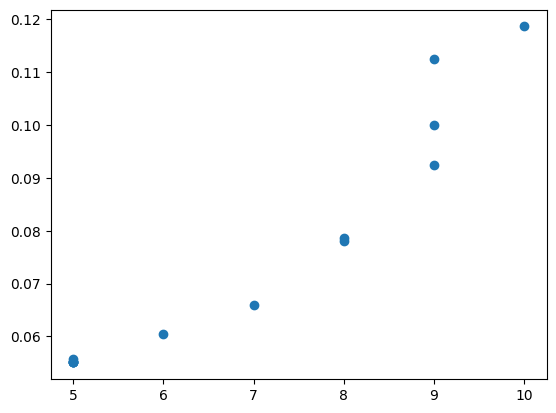

In [206]:
plt.scatter(grapf[6:,0],grapf[6:,1])

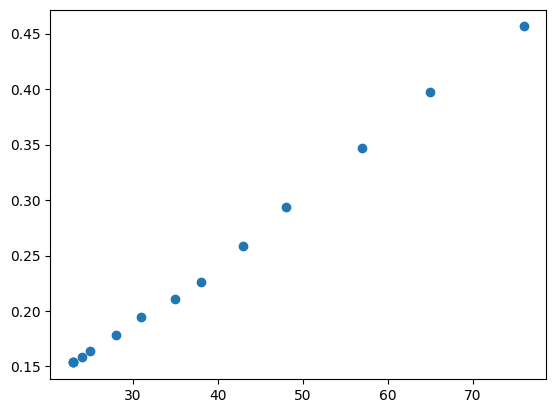

In [207]:
plt.scatter(grapf1[6:,0],grapf1[6:,1])

In [24]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u


coord = SkyCoord(f'{head["RA"]} {head["DEC"]}', 
                 unit=("hourangle","deg"), 
                 frame="icrs", 
                 obstime=f'{head["DATE-OBS"]}T{head["TIME-OBS"]}'
)

UCAC = Vizier(catalog="I/340")
UCAC.ROW_LIMIT = -1
result = UCAC.query_region(coordinates=coord,
                          width=4*u.deg,height=3*u.deg,
                          column_filters={'Gmag': '<8'})


In [70]:
import pandas as pd
radec = np.array(np.array(result[0][["RAJ2000","DEJ2000"]]).tolist(),dtype=float)
pd.DataFrame(radec)

,0,1
0,338.192409,3.005117
1,339.956857,3.242453
2,341.408354,3.631162
3,340.961334,3.886908
4,340.720822,4.968822
5,338.749436,4.162727
6,340.588305,5.173748


In [77]:
from twirl import find_peaks

xyT = find_peaks(data)[0:20]
xyT

array([[ 30.04886748,  76.79283734],
       [716.81240565, 368.93112957],
       [163.49036537, 181.04419748],
       [ 15.88960058, 387.03956591],
       [ 18.92058734, 238.16781016],
       [258.83280301, 268.03447645],
       [428.73913906,  19.48326034],
       [167.60688761,  12.04568679],
       [129.64398115,  62.50363021],
       [ 75.49787176, 209.48030024],
       [328.6584148 , 287.35099802],
       [ 96.83649301, 179.42398237],
       [174.35380375, 119.56440585],
       [ 91.29926282, 505.48699545],
       [581.2042221 ,  77.50298916],
       [ 87.61914949,  57.48080176],
       [ 74.92156235, 356.64193282],
       [616.52572618, 107.54832013],
       [233.88224285,  44.53568037],
       [306.51973726, 395.51093484]])

In [72]:
xy

[[192.026895319703, 148.92046216754053],
 [163.0213801242751, 180.9055160150819],
 [258.0687144124922, 267.99789320555885],
 [328.07777375805887, 287.8742442797312],
 [87.96854542880911, 363.9034797412008],
 [716.9533136596339, 369.13261360156196],
 [509.0098825148932, 373.0146535791596],
 [486.9659151675747, 380.033910167205],
 [683.0163723893095, 381.93443108430955],
 [15.059243578768374, 387.9891908747001]]

In [76]:
from twirl import compute_wcs

wcs = compute_wcs(xyT,pd.DataFrame(radec))

ValueError: Cannot parse coordinates from first argument

In [273]:
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (158.77295833, 21.62232861)>

In [21]:
head

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  576                                                  
NAXIS2  =                  768                                                  
                                                                                
BSCALE  =                  1.0                                                  
BZERO   =                    0                                                  
DATAMIN =                    0                                                  
DATAMAX =                65535                                                  
TYPE    =                       1                                               
                                                                                
DATE-OBS= '2024-09-08'      

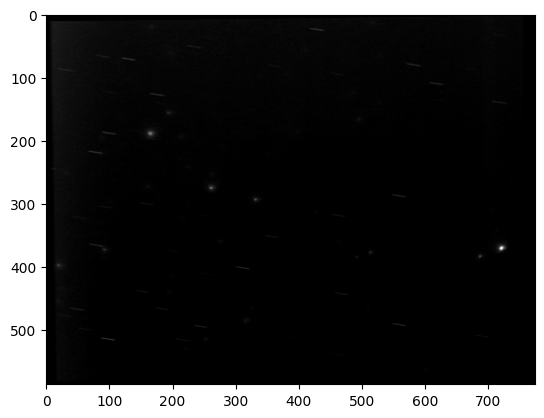

In [20]:
from scipy import ndimage
from astropy.coordinates import Angle

rotated = ndimage.rotate(data,Angle(f'{head["TA"]} degrees').to_value(u.deg))
plt.imshow(rotated, vmin=np.median(data), cmap="Greys_r")


In [260]:
Angle(f'{head["TA"]} hours').to_value(u.deg)

123.08444999999998

In [276]:
Vizier.clear_cache()

<h1> Test WCS from astropy

In [78]:
from astropy.wcs import WCS
wcs = WCS(head)

In [79]:
wcs.all_pix2world(30,40,0)

[array(31.), array(41.)]